# AlphaFold 3 PG fragments experimentation

Playing around with providing PG fragments as ligands to AF3.

In [51]:
import json
import os
from pathlib import Path
import random

from Bio import SeqIO
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromPDBFile
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule, UFFOptimizeMolecule
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import BondType
import gemmi
from IPython.display import display

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
data_folder = Path('./data/')
assert data_folder.is_dir()

In [33]:
def gen_model_seeds(n):
    return [int(random.uniform(1, 100)) for _ in range(n)]

## Load & display PG fragment

PG fragment extracted from [7Q4T](https://www.rcsb.org/structure/7Q4T) – "Structure of the Pseudomonas aeruginosa bacteriophage JG004 endolysin Pae87 bound to a peptidoglycan fragment"

It is made of two glycans, GlcNAC and MurNAC, and one peptide stem from the cell wall of _P. aeruginosa_.

In [43]:
pdb_file = data_folder / 'AF3' / '7q4t_PG_fragment.pdb'
mol = MolFromPDBFile(pdb_file.resolve().as_posix())
Compute2DCoords(mol)
smiles = Chem.MolToSmiles(mol)
smiles

'CC(O)N[C@@H]1[C@@H](O[C@H](C)C(O)N[C@@H](C)C(=O)N[C@H](CCC(O)O)C(O)O)[C@H](O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2NC(C)O)[C@@H](CO)O[C@@H]1O'

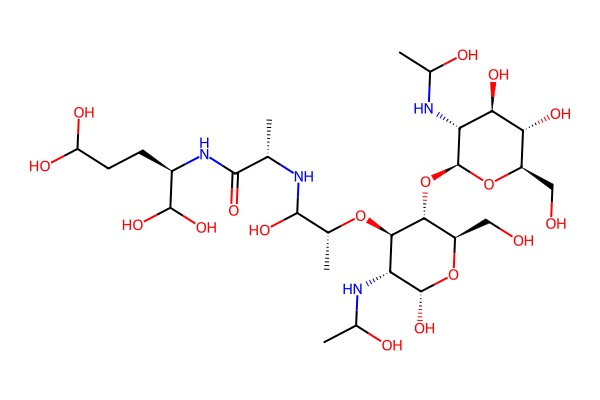

In [44]:
img = Draw.MolToImage(mol, size=(600, 400), dpi=300)
display(img)

## Load deacetylated version

In [45]:
pdb_file_deac = data_folder / 'AF3' / '7q4t_PG_fragment_deacetylated.pdb'
mol_deac = MolFromPDBFile(pdb_file_deac.resolve().as_posix())
Compute2DCoords(mol_deac)
smiles_deac = Chem.MolToSmiles(mol_deac)
smiles_deac

'C[C@H](NC(O)[C@@H](C)O[C@@H]1[C@@H]([NH3+])[C@@H](O)O[C@H](CO)[C@H]1O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1[NH3+])C(=O)N[C@H](CCC(O)O)C(O)O'

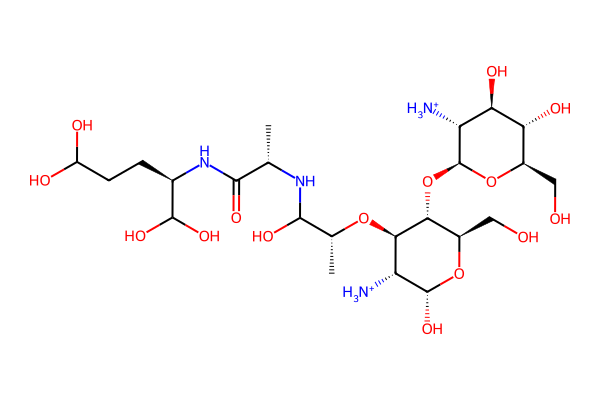

In [46]:
img_deac = Draw.MolToImage(mol_deac, size=(600, 400), dpi=300)
display(img_deac)

## Make AF compatible JSON files

Spec: https://github.com/google-deepmind/alphafold3/blob/main/docs/input.md

We'll load the sequence form the Human Lysozyme protein ([P61626](https://www.uniprot.org/uniprotkb/P61626/entry)).

In [56]:
seq_record = list(SeqIO.parse(data_folder / 'AF3' / 'Human_Lysozyme_P61626.fasta', 'fasta'))[0]

lysozyme_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(seq_record.seq).upper()
    },
}

In [57]:
pg_acetylated_sequence = {
    'ligand': {
        'id': 'B',
        'smiles': smiles,
    }
}
pg_deacetylated_sequence = {
    'ligand': {
        'id': 'B',
        'smiles': smiles_deac,
    }
}

In [ ]:
data_acetylated = {
    'name': 'LYZ_PG_acetylated',
    'sequences': [
        lysozyme_sequence,
        pg_acetylated_sequence,
    ],
    'modelSeeds': gen_model_seeds(3),
    'dialect': 'alphafold3',
    'version': 1,
}
data_deacetylated = {
    'name': 'LYZ_PG_deacetylated',
    'sequences': [
        lysozyme_sequence,
        pg_deacetylated_sequence,
    ],
    'modelSeeds': gen_model_seeds(3),
    'dialect': 'alphafold3',
    'version': 1,
}

In [59]:
with (data_folder / 'AF3' / 'LYZ_PG_acetylated.json').open('w') as f_out:
    json.dump(
        data_acetylated, 
        f_out,
        indent=True,
    )
with (data_folder / 'AF3' / 'LYZ_PG_deacetylated.json').open('w') as f_out:
    json.dump(
        data_deacetylated, 
        f_out,
        indent=True,
    )

## PG hexamuropeptide

From https://www.rcsb.org/structure/2mtz

In [67]:
PG_hexamuropeptide_file = data_folder / 'AF3' / 'PG_hexamuropeptide.pdb'
PG_hexamuropeptide_mol = MolFromPDBFile(PG_hexamuropeptide_file.resolve().as_posix())
#PG_hexamuropeptide_mol = Chem.AddHs(PG_hexamuropeptide_mol)
#EmbedMolecule(PG_hexamuropeptide_mol)
UFFOptimizeMolecule(PG_hexamuropeptide_mol)
#PG_hexamuropeptide_mol = Chem.AddHs(PG_hexamuropeptide_mol)
PG_hexamuropeptide_SMILES = Chem.MolToSmiles(PG_hexamuropeptide_mol)

[16:56:26] Molecule does not have explicit Hs. Consider calling AddHs()


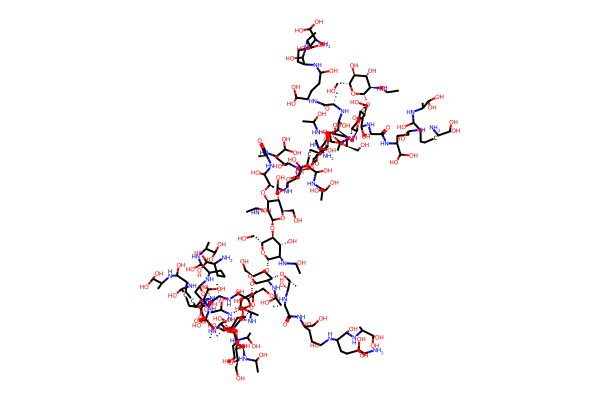

In [68]:
img = Draw.MolToImage(PG_hexamuropeptide_mol, size=(600, 400), dpi=300)
display(img)

In [41]:
def generate_ccd(input_pdb, ligand_name):
    """
    Generate a user-provided CCD file for AlphaFold 3 using RDKit for parsing
    and Gemmi for writing the mmCIF format.

    Args:
        input_pdb (str): Path to the input PDB file containing the ligand.
        output_ccd_file (str): Path to the output CCD mmCIF file.
        ligand_name (str): The three-letter residue name of the ligand (e.g., ATP).
    """

    # Load the PDB file into RDKit
    mol = Chem.MolFromPDBFile(input_pdb, removeHs=False)
    if mol is None:
        raise ValueError("Failed to parse the input PDB file. Ensure it contains valid ligand information.")

    # Generate 3D coordinates if missing
    if not mol.GetConformer():
        print("No conformer found. Generating 3D coordinates...")
        AllChem.EmbedMolecule(mol, randomSeed=42)
    
    AllChem.UFFOptimizeMolecule(mol)

    # Extract atom and bond information
    atoms = []
    bonds = []
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    molecular_weight = Chem.rdMolDescriptors.CalcExactMolWt(mol)

    for atom in mol.GetAtoms():
        coords = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        atoms.append({
            "id": atom.GetIdx(),
            "element": atom.GetSymbol(),
            "charge": atom.GetFormalCharge(),
            "coords": coords,
            "leaving": "N"  # Default: not a leaving atom
        })

    bond_type_mapping = {
        BondType.SINGLE: ("SING", "N"),
        BondType.DOUBLE: ("DOUB", "N"),
        BondType.TRIPLE: ("TRIP", "N"),
        BondType.AROMATIC: ("AROM", "Y"),
    }

    for bond in mol.GetBonds():
        bond_type, aromatic_flag = bond_type_mapping.get(bond.GetBondType(), ("SING", "N"))
        bonds.append({
            "atom1": bond.GetBeginAtomIdx(),
            "atom2": bond.GetEndAtomIdx(),
            "order": bond_type,
            "aromatic": aromatic_flag
        })

    # Create the mmCIF document
    doc = gemmi.cif.Document()
    block = doc.add_new_block(f"{ligand_name}")

    # Add _chem_comp metadata
    block.set_pair('_chem_comp.id', ligand_name)
    block.set_pair('_chem_comp.name', ligand_name)
    block.set_pair('_chem_comp.type', 'non-polymer')
    block.set_pair('_chem_comp.formula', formula)
    block.set_pair('_chem_comp.formula_weight', f"{molecular_weight:.3f}")
    block.set_pair('_chem_comp.mon_nstd_parent_comp_id', '?')
    block.set_pair('_chem_comp.pdbx_synonyms', '?')

    # Add atoms to _chem_comp_atom
    atom_loop = block.init_loop('_chem_comp_atom.', [
        'comp_id', 'atom_id', 'type_symbol', 'charge',
        'pdbx_model_Cartn_x_ideal', 'pdbx_model_Cartn_y_ideal', 'pdbx_model_Cartn_z_ideal', 'pdbx_leaving_atom_flag'
    ])
    for atom in atoms:
        atom_loop.add_row([
            ligand_name, f"{atom['element']}{atom['id'] + 1}", atom['element'], str(atom['charge']),
            f"{atom['coords'].x:.3f}", f"{atom['coords'].y:.3f}", f"{atom['coords'].z:.3f}", atom['leaving']
        ])

    # Add bonds to _chem_comp_bond
    bond_loop = block.init_loop('_chem_comp_bond.', [
        'comp_id', 'atom_id_1', 'atom_id_2', 'value_order', 'pdbx_aromatic_flag'
    ])
    for bond in bonds:
        atom1 = f"{atoms[bond['atom1']]['element']}{bond['atom1'] + 1}"
        atom2 = f"{atoms[bond['atom2']]['element']}{bond['atom2'] + 1}"
        bond_loop.add_row([ligand_name, atom1, atom2, bond['order'], bond['aromatic']])

    # Write the mmCIF file
    #doc.write_file(output_ccd_file)
    #print(f"CCD mmCIF file saved to: {output_ccd_file}")

    # Convert the mmCIF document to a string
    ccd_content = doc.as_string()
    # Replace newline characters for JSON compatibility
    #ccd_content = ccd_content.replace('\n', '\\n')

    return ccd_content

In [42]:
# Example usage:
input_pdb = (data_folder / 'AF3' / 'PG_hexamuropeptide.pdb').as_posix()
ligand_name = "LIG-PG"

pg_hexamuropeptide_ccd = generate_ccd(input_pdb, ligand_name)
pg_hexamuropeptide_ccd

[23:21:29] Molecule does not have explicit Hs. Consider calling AddHs()


'data_LIG-PG\n_chem_comp.id LIG-PG\n_chem_comp.name LIG-PG\n_chem_comp.type non-polymer\n_chem_comp.formula C222H452N42O121\n_chem_comp.formula_weight 5643.051\n_chem_comp.mon_nstd_parent_comp_id ?\n_chem_comp.pdbx_synonyms ?\n\nloop_\n_chem_comp_atom.comp_id\n_chem_comp_atom.atom_id\n_chem_comp_atom.type_symbol\n_chem_comp_atom.charge\n_chem_comp_atom.pdbx_model_Cartn_x_ideal\n_chem_comp_atom.pdbx_model_Cartn_y_ideal\n_chem_comp_atom.pdbx_model_Cartn_z_ideal\n_chem_comp_atom.pdbx_leaving_atom_flag\nLIG-PG N1 N 0 17.846 10.164 -6.601 N\nLIG-PG C2 C 0 18.171 8.924 -7.320 N\nLIG-PG C3 C 0 19.597 8.910 -7.706 N\nLIG-PG O4 O 0 20.380 9.801 -7.220 N\nLIG-PG C5 C 0 17.301 8.801 -8.585 N\nLIG-PG N6 N 0 20.170 7.733 -8.266 N\nLIG-PG C7 C 0 21.530 7.720 -8.841 N\nLIG-PG C8 C 0 21.948 6.298 -9.246 N\nLIG-PG O9 O 0 23.350 6.183 -9.176 N\nLIG-PG C10 C 0 21.567 8.688 -10.001 N\nLIG-PG C11 C 0 22.980 8.849 -10.507 N\nLIG-PG C12 C 0 22.972 9.278 -11.957 N\nLIG-PG O13 O 0 22.259 8.355 -12.744 N\nLIG-P

## PG fragment from Streptococcus pneumoniae

https://www.rcsb.org/structure/5ctv

[23:57:58] Molecule does not have explicit Hs. Consider calling AddHs()


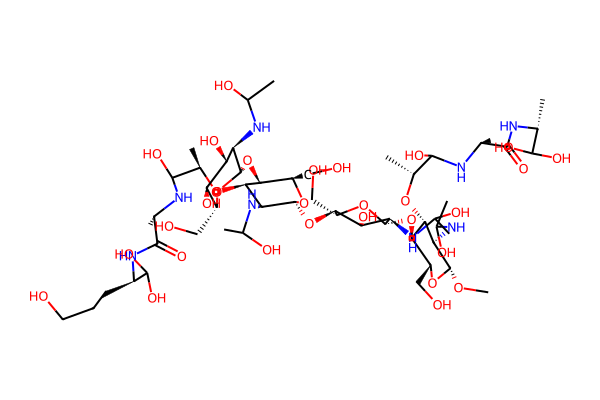

In [49]:
PG_fragment_5ctv_path = data_folder / 'AF3' / '5ctv_PG_fragment.pdb'
PG_fragment_5ctv_mol = MolFromPDBFile(PG_fragment_5ctv_path.resolve().as_posix())
AllChem.UFFOptimizeMolecule(PG_fragment_5ctv_mol)
PG_fragment_5ctv_SMILES = Chem.MolToSmiles(PG_fragment_5ctv_mol, canonical=False)

img = Draw.MolToImage(PG_fragment_5ctv_mol, size=(600, 400), dpi=300)
display(img)

In [56]:
PG_fragment_5ctv_ccd = generate_ccd(PG_fragment_5ctv_path, 'LIG-PG-5ctv')

[10:44:18] Molecule does not have explicit Hs. Consider calling AddHs()


LysM x3 from Lactococcus lactis:

In [57]:
lysM_fasta_path = data_folder / 'AF3' / 'LysM' / 'acmA_A2RHZ5_LysM_241_437.fasta'
lysM_record = list(SeqIO.parse(lysM_fasta_path, 'fasta'))[0]
lysM_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(lysM_record.seq).upper()
    },
}

LysM x1 from Streptococcus pneumoniae:

In [58]:
lysM_Strep_fasta_path = data_folder / 'AF3' / 'LysM' / 'A0A4J1R814_S_pneumoniae_LysM_266_312.fasta'
lysM_Strep_record = list(SeqIO.parse(lysM_Strep_fasta_path, 'fasta'))[0]
lysM_Strep_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(lysM_Strep_record.seq).upper()
    },
}

LysM x1 from B. subtilis:

In [64]:
lysM_Bacillus_fasta_path = data_folder / 'AF3' / 'LysM' / 'LysM_B_subtilis_O07532_27_70.fasta'
lysM_Bacillus_record = list(SeqIO.parse(lysM_Bacillus_fasta_path, 'fasta'))[0]
lysM_Bacillus_sequence = {
    'protein': {
        'id': 'A',
        'sequence': str(lysM_Bacillus_record.seq).upper()
    },
}

In [61]:
data_LysM_PG = {
    'name': 'LysM_PG',
    'sequences': [
        lysM_Strep_sequence,
        {
            'ligand': {
                'id': 'B',
                'ccdCodes': ['LIG-PG-5ctv'],
            }
        },
    ],
    'modelSeeds': gen_model_seeds(5),
    'userCCD': PG_fragment_5ctv_ccd,
    'dialect': 'alphafold3',
    'version': 1,
}

with (data_folder / 'AF3' / 'LysM' / 'LysM_A0A4J1R814_266_312_vs_PG_5ctv.json').open('w') as f_out:
    json.dump(
        data_LysM_PG, 
        f_out,
        indent=True,
    )

In [66]:
data_LysM_PG_ccd = {
    'name': 'LysM_PG',
    'sequences': [
        lysM_Bacillus_sequence,
        {
            'ligand': {
                'id': 'B',
                'ccdCodes': ['LIG-PG']
            }
        },
    ],
    'modelSeeds': gen_model_seeds(5),
    'dialect': 'alphafold3',
    'userCCD': pg_hexamuropeptide_ccd,
    'version': 1,
}

with (data_folder / 'AF3' / 'LysM' / 'LysM_B_subtilis_O07532_27_70_vs_PG_hexamuropeptide.json').open('w') as f_out:
    json.dump(
        data_LysM_PG_ccd, 
        f_out,
        indent=True,
    )

Notes on how AF3 processes ligand specified as user-provided CCD mmCIF data: https://github.com/google-deepmind/alphafold3/issues/212